<a href="https://colab.research.google.com/github/mikodham/CS470/blob/main/BaselineCode_Gideb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [1]:
''' INITIALIZATION '''
# 1st option, upload on ur gdrive
# from google.colab import files
# files.upload()
# 2nd option, just drag the folder from your folder to drive/content/

import os 
import urllib
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
password = urllib.parse.quote(password)
os.environ['GITHUB_AUTH'] = user + ':' + password
del password

# 3rd option, git clone
!pwd
!rm -rf descry-gideb_trial  # FOR UPDATING DATASET DO NOT RUN THIS LINE
!git clone https://$GITHUB_AUTH@github.com/mikodham/descry-gideb_trial.git 

del os.environ['GITHUB_AUTH']


GitHub user··········
GitHub password··········
/content
Cloning into 'descry-gideb_trial'...
remote: Enumerating objects: 3935, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 3935 (delta 84), reused 179 (delta 82), pack-reused 3754
Receiving objects: 100% (3935/3935), 548.64 MiB | 39.24 MiB/s, done.
Resolving deltas: 100% (450/450), done.


In [2]:
#Set-up Directory
gitdir = os.path.join(os.getcwd(), "descry-gideb_trial")
gitdir


'/content/descry-gideb_trial'

In [3]:
#REQUIREMENTS, #don't forget to turn on gpu
!pip3 install sklearn gensim xgboost keras konlpy~=0.5.2 emoji
!pip3 install nltk~=3.5
!sudo apt-get install g++ openjdk-8-jdk curl
!pip3 install -r descry-gideb_trial/requirements.txt


     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 184 kB 64.6 MB/s 
     |████████████████████████████████| 86 kB 7.4 MB/s 
     |████████████████████████████████| 448 kB 51.8 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=d4a197d60d08580bc96f543affd605bbfac810da9925620e4bab0a09f13df8db
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 1.5 MB 8.5 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is 

In [4]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import argparse
import emoji
import re

2.5.0


In [5]:
import nltk
import konlpy 
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [6]:
import random
# DO NOT EDIT THE FOLLOWING LINES
# THESE LINES ARE FOR REPRODUCIBILITY
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

#PREPROCESSING
1. Load Dataset
2. Pre-process sentence into features



#EXTRACT DATASET: TRAIN+TEST



In [7]:
#Datastructure to  extract dataset

def load_dataset(files, cols, positive=False):
  '''
  files = list of path files
  cols = usecols (e.g cols="B,E" or "B:E")
  positive = True when loading suicidal-only dataset without ground truth
  return master_df
  '''
  master_df = pd.DataFrame()
  for file in files:
    dfs = pd.read_excel(file,sheet_name=[0],usecols=cols,skiprows=[]) # 1 dataframe for each sheet within an excel file
    df = pd.concat(dfs,ignore_index=True) # merging the dataframes for each sheet
    master_df = pd.concat([master_df,df],ignore_index=True) # merging the dataframes for each file
  del dfs, df

  # Clean Dataset
  if positive:
    master_df.loc[:,"Ground-Truth"] = True
    # df_all = pd.concat([master_df, new_gt], axis=1)
  else:
    keys = master_df.keys().tolist()
    master_df[keys[1]] = (master_df[keys[1]] == 'Y').astype(bool)

  keys = master_df.keys().tolist()
  print("keys are ", keys)
  #rename ground truth class as not-key, but "ground-truth"
  master_df = master_df.rename(columns={keys[0]: "Sentence"}) 
  master_df = master_df.rename(columns={keys[1]: "Ground-Truth"})

  master_df.dropna(subset = ["Sentence"], inplace=True) 
  return master_df


def combine(dfa, dfb):
  return pd.concat([dfa, dfb], axis=0).sample(frac=1).reset_index(drop=True)


def get_posneg(master_df, positive=5, negative=5, key_loc=1):
  """
  master_df= original df that needs to be splitted
  positive= how many positive suicidal sentence to extract
  negative= how many non-suicidal sentence to extract
  condition = 
  Return df_all: with Ground truth
  """
  df_positives = master_df[master_df[master_df.keys()[1]].isin([True])]
  df_negatives = master_df[master_df[master_df.keys()[1]].isin([False])]
  # # df_negatives.reset_index(drop=True,inplace=True)
  if positive==0 and negative==0:
      raise ValueError("no sample is taken")
  if positive==0:
      df_all = df_negatives.sample(negative)
  elif negative==0:
      df_all = df_positives.sample(positive)
  else:
      df_all = pd.concat([df_positives.sample(positive), df_negatives.sample(negative)], axis=0)
  print("shapes: ", len(df_positives.index), len(df_negatives.index))
  print("shape: ", len(df_all.index))
  df_all = df_all.sample(frac=1).reset_index(drop=True) # Randomize
  # print(df_positives.head(10))
  return df_all


def split(master_df, train=10, test=10, percent=None):
  """
  split training and test
  Return train_features, train_truth, test_features, test_truth
  """
  if percent==None:
    pass
    #set train and test
  #split

  return train_features, train_truth, test_features, test_truth



In [10]:
train_files = [
  # TODO: Warn: Format is different need to change xlsx file labels
  os.path.join(gitdir, "dataset", "Scraping_4th_week_of_Fed_Suicidal.xlsx"), # the correct data  
]

data_df = load_dataset(files=train_files, cols="B,E", positive=False)
# data_df
train_files = [
  # TODO: Warn: Format is different need to change xlsx file labels
  os.path.join(gitdir, "dataset", "Suicidal Texts Compilation (All Y's).xlsx")
]
data2_df = load_dataset(files=train_files, cols="B", positive=True)

data_df = combine(data_df, data2_df)


test_files = [
  os.path.join(gitdir, "dataset", "핵심 단어 목록.xlsx")
]

keys are  ['Post/Sentence', 'Suicidal (Y/N)']
keys are  ['Post/Sentence', 'Ground-Truth']


In [37]:
data_df

,Sentence,Ground-Truth
0,요즘 저랑 증상이 비슷하시네요..\n너무 힘드네요 저도\n특히 직장생활이 너무 힘들...,False
1,없는 사실에 매달리는게 정상적인 삶이 아닙니다. 지나친 열정은 분노를 낳을 수 밖에...,False
2,전 세로켈.리튬.라믹탈 먹고 있어요. 리스페리돌은 모르겠고.. 전 현재 체중증가는 ...,False
3,안타깝네요.\n상태는 어떠세요? 심하세요?\n엄마 본인의 병을 인식하시나요?\n\n...,False
4,와 2년이나 운동하셨네요. 지금도 하시나요? 대단하시네요. 그리고 글 내용도 너무 ...,False
...,...,...
2414,저는 쿠에타핀 때문에 하지불안증후군 와서 뺐어요ㅜㅜ\n\n,False
2415,직접 본게아니라 말씀드리기 꺼려지지만 비슷하긴 합니다\n\n,False
2416,일단 약먹고 잘챙겨먹고요ㆍ님도 우울해지니 잘드시고요ㆍ애기랑 힘들면 안되요ㆍ10개월 ...,False
2417,"항우울제,\n\n​\n\n조울증 성향이 없는 사람들은, 항우울제를 복용해도 조증이 ...",False


In [38]:
#Learn How to iterate those
# df_negatives.iloc[100] #text:[0], class:[1]
# df_positives #reddit post and suicide risk
# df_negatives[keys[1]]

##Dataset Tensorflow

In [39]:
# TODO: Find the right data structure to match tensorflow dataset, so that the train and test data
# will be trainable

# Reference: https://www.tensorflow.org/datasets/add_dataset
# TODO: Later, for more Classifications, need custom datasets
# Negative: Q불안장애Anxiety, W트라우마PTSD, E우울증Depression, R조울증Bipolar, T강박장애OCD, Y무기력Lethargy, U과잉행동장애ADHD, I공황장애Panic disorder
# Positive: A응원Encourage S극복Overcome D다짐Decide F추억Remind G깨달음Realized H감사Gratitude J사과Apology K고백Confession L용서Forgiveness

#Features Extraction

In [40]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

kkma = konlpy.tag.Kkma()

In [41]:
#TESTING KONLPY
'''

# every = "my name is 미코. 제가 21살이야. 반갑습니다"
every = "집에 오면 내 편은 아무도 없고 우울하기만 합니다 어떻게 해야 할까요"
every = "생각많은것도 에너지 고갈된다😣😓, 노래듣고 재밌는 프로 보면서 즐겁게 쉬자🔥"
# every = "마인드까페👍 상담사님들👍💕" # KKMA can't work on emoticons, why? KKMA uses UTF-8!

#1st try
every = '생각많은것도 에너지 고갈된다😣😓, 노래듣고😣😓 재밌는 프로 보면서 즐겁게 쉬자🔥'
print("tokens: ", nltk.word_tokenize(every))
print(len(every), every.split()) #emoticon is not alphabet, korean texts ARE
print(every.split()[0].isalpha())
after = every.encode('latin1', errors = "replace")
print(type(after))
POS = kkma.pos(after)
# print(after.decode("utf-8"))
 # 'latin-1''utf-8' 'unicode-escape' ("utf-8", errors = "replace")
print(POS) # ERROR
#2 
#we can define emoticon as new feature later
# count number of emoticons
# for char in every
import emoji
import re

emojis = ''.join(c for c in every if c in emoji.UNICODE_EMOJI['en'])
non_emoji_sents = deEmojify(every)
POS = kkma.pos(non_emoji_sents)
print("FINAL POS", POS)

text = "입맛이 없고 나른해지면서 아무 생각이 없어지는 걸 보니 울기가 시작되려나 보네요 일찍 병원에 갔다가 다시 약조절 하고 간만에 스벅 왔는데 그 좋아하는 샌드위치를 봐도 감흥이 없어요 이 시기에 살이나 빼야겠어요 다들 주말 무사히 보내세요~"
POS = kkma.pos(text)
POS # ~ has POS of "SO"
'''

'\n\n# every = "my name is 미코. 제가 21살이야. 반갑습니다"\nevery = "집에 오면 내 편은 아무도 없고 우울하기만 합니다 어떻게 해야 할까요"\nevery = "생각많은것도 에너지 고갈된다😣😓, 노래듣고 재밌는 프로 보면서 즐겁게 쉬자🔥"\n# every = "마인드까페👍 상담사님들👍💕" # KKMA can\'t work on emoticons, why? KKMA uses UTF-8!\n\n#1st try\nevery = \'생각많은것도 에너지 고갈된다😣😓, 노래듣고😣😓 재밌는 프로 보면서 즐겁게 쉬자🔥\'\nprint("tokens: ", nltk.word_tokenize(every))\nprint(len(every), every.split()) #emoticon is not alphabet, korean texts ARE\nprint(every.split()[0].isalpha())\nafter = every.encode(\'latin1\', errors = "replace")\nprint(type(after))\nPOS = kkma.pos(after)\n# print(after.decode("utf-8"))\n # \'latin-1\'\'utf-8\' \'unicode-escape\' ("utf-8", errors = "replace")\nprint(POS) # ERROR\n#2 \n#we can define emoticon as new feature later\n# count number of emoticons\n# for char in every\nimport emoji\nimport re\n\nemojis = \'\'.join(c for c in every if c in emoji.UNICODE_EMOJI[\'en\'])\nnon_emoji_sents = deEmojify(every)\nPOS = kkma.pos(non_emoji_sents)\nprint("FINAL POS", POS)\n\ntext = "입맛이 없고

In [42]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def get_all_tags(data):
    print("Processing POS features ...")
    tags_all = []
    for title in data:
        emojis = ''.join(c for c in title if c in emoji.UNICODE_EMOJI['en'])
        non_emoji_sents = deEmojify(title)
        tagged_text = kkma.pos(non_emoji_sents)
        # tagged_text = kkma.pos(title)
        for word, tag in tagged_text:
            if tag not in tags_all:
                tags_all.append(tag)
    return tags_all


def f_pos(data, tags_all):
    tag_dict, tag_count = {}, {}
    for tag in tags_all:
        tag_dict[tag] = 0
        tag_count[tag] = []
    for title in data:
        # every = nltk.word_tokenize(title)      
        # print(title)
        emojis = ''.join(c for c in title if c in emoji.UNICODE_EMOJI['en'])
        non_emoji_sents = deEmojify(title)
        tagged_text = kkma.pos(non_emoji_sents)
        # tagged_text = kkma.pos(title) # tagged_text = nltk.pos_tag(nltk.word_tokenize(title)) 
        for word, tag in tagged_text:
            tag_dict[tag]+=1
        for count,tag in zip(tag_dict.values(), tag_dict.keys()):
            tag_count[tag].append(count)
    return pd.DataFrame(tag_count, index=None)


def f_basic(data):
    print("Processing basic features ...")
    num_title_words, num_title_token, num_title_char, num_emojis = [], [], [], []
    for title in data:
        num_title_words.append(len(title.split()))
        # print(title) #avoid emoticons
        emojis = ''.join(c for c in title if c in emoji.UNICODE_EMOJI['en'])
        non_emoji_sents = deEmojify(title)
        tagged_text = kkma.pos(non_emoji_sents)
        tokens = [word for word, tag in tagged_text]
        num_title_token.append(len(tokens))
        num_title_char.append(len(title))
        num_emojis.append(len(emojis))
    print("Processing basic features ... Almost Done")
    features = {'title_words': num_title_words, 'title_token': num_title_token, 'title_char': num_title_char,'title_emojis': num_emojis}
    print("Processing basic features ... Done")
    return pd.DataFrame(features, columns=['title_words', 'title_token', 'title_char','title_emojis'])


def f_tfidf(data):
    print("Processing TF-IDF features ...")
    X = data
    count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 1), max_features=50)
    X_counts = count_vect.fit_transform(X)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_counts)
    df_tfidf = pd.DataFrame(X_train_tfidf.todense())
    return df_tfidf

  
def features(data): ### Features Extraction 
  df_basic = f_basic(data)
  df_tfidf = f_tfidf(data)
  tags_all = get_all_tags(data)
  df_pos = f_pos(data, tags_all)
  df_features = pd.concat([df_basic,  df_pos], axis=1) \
  #df_tfidf # NOTE THAT TF IDF IS NOT INCLUDED
  return df_features

# Run Features IGNORE FOR NOW

In [43]:
# list(df_negatives_zenodo['Reddit Post'])

# def get_zenodo(n_train, n_valid, n_pred): 
'''
n_train,  n_pred = 500, 700

  zenodo: Negative 1609 ['supportive','uninformative']
          Positive 778 ['attempt','behavior','indicator','ideation']
  Index of Extraction: n_train < n_pred
  Maximum n_pred is 750
  Return Dataset for 6 classifications, balanced data between positive and negative

import random
if n_pred > 750: raise AssertionError("n_pred exceeds")
if (n_train < n_pred) is False: raise AssertionError("Input Order Error")
positive_sents = list(df_positives_zenodo['Reddit Post'][:n_pred])
# print(type(positive_sents))
negative_sents = list(df_negatives_zenodo['Reddit Post'][:n_pred])
extracted_sentences = positive_sents + negative_sents # list of all sentences in the corpus
extracted_sentences = [str(sent) for sent in extracted_sentences] 

extracted_labels = list(df_positives_zenodo['Suicide Risk'][:n_pred])
extracted_labels += list(df_negatives_zenodo['Suicide Risk'][:n_pred])
labels = ['supportive','uninformative','attempt','behavior','indicator','ideation']
extracted_labels = [labels.index(each) for each in extracted_labels]

# Shuffle
seed = random.random()
random.seed(seed) 
random.shuffle(extracted_sentences)
random.seed(seed)
random.shuffle(extracted_labels)
# # Shuffle
# indices = np.arange(extracted_sentences.shape[0])
# np.random.shuffle(indices)
# extracted_sentences = extracted_sentences[indices]
# extracted_labels = extracted_labels[indices]

# TRAIN
train_sentences = extracted_sentences[:n_train]
train_labels = extracted_labels[:n_train]

# TEST
test_sentences = extracted_sentences[n_train:n_pred]
test_labels = extracted_labels[n_train:n_pred]
# print(corY_labels)
# Should I convert into digits of classes?
'''



'\nn_train,  n_pred = 500, 700\n\n  zenodo: Negative 1609 [\'supportive\',\'uninformative\']\n          Positive 778 [\'attempt\',\'behavior\',\'indicator\',\'ideation\']\n  Index of Extraction: n_train < n_pred\n  Maximum n_pred is 750\n  Return Dataset for 6 classifications, balanced data between positive and negative\n\nimport random\nif n_pred > 750: raise AssertionError("n_pred exceeds")\nif (n_train < n_pred) is False: raise AssertionError("Input Order Error")\npositive_sents = list(df_positives_zenodo[\'Reddit Post\'][:n_pred])\n# print(type(positive_sents))\nnegative_sents = list(df_negatives_zenodo[\'Reddit Post\'][:n_pred])\nextracted_sentences = positive_sents + negative_sents # list of all sentences in the corpus\nextracted_sentences = [str(sent) for sent in extracted_sentences] \n\nextracted_labels = list(df_positives_zenodo[\'Suicide Risk\'][:n_pred])\nextracted_labels += list(df_negatives_zenodo[\'Suicide Risk\'][:n_pred])\nlabels = [\'supportive\',\'uninformative\',\'at

In [44]:
# vocab_size, bow_features, tfidf_features = BOW_TFIDF(train_sentences)
# #Warning: This takes a long Time!

# print(tfidf_features[200])

# Model: RNN

In [115]:
def arg_rnn():
    parser = argparse.ArgumentParser()
    parser.add_argument('--max_seq_len', type=int, default=1000, help="max length of sequences")
    parser.add_argument('--max_num_words', type=int, default=20000, help="max number of words")
    parser.add_argument('-d', '--embedding_dim', type=int, default=500, help="embedding dimension")
    parser.add_argument('--rnn_units', type=int, default=128, help="units of RNN")
    parser.add_argument('--dropout_rate', type=float, default=0.1, help='dropout rate')
    parser.add_argument('--dense_units', type=int, default=32, help="units of Dense layer")
    parser.add_argument('--embedding_type', type=str, default='word2vec', help="the type of word embedding")
    parser.add_argument('--valid_split', type=float, default=0.1, help="ratio of validation split")
    parser.add_argument('-act', '--activation', type=str, default='relu', help="type of activation function")
    parser.add_argument('--patience', type=int, default=10, help="number of epochs with no improvement after which training will be stopped")
    parser.add_argument('--batch_size', type=int, default=64, help="batch size")
    parser.add_argument('--epochs', type=int ,default=20, help="training epochs")
    # args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    return args

In [117]:
def build_RNN(args):
    model = tf.keras.Sequential([
      tf.keras.layers.Embedding(100000, args.embedding_dim), 
      tf.keras.layers.SimpleRNN(128, return_sequences=True),
      tf.keras.layers.GlobalMaxPool1D(),
      # tf.keras.layers.Dropout(args.dropout_rate),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(args.dense_units, activation="relu"),
      # tf.keras.layers.Dropout(args.dropout_rate),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['BinaryAccuracy'])#sparse_categorical_crossentropy #accuracy
    return model

In [47]:
# def build_RNN(args):
#     # TODO: Tim, please modify this part use tf.keras instead of keras.model
#     # model = tf.keras.Sequential([
#     #     tf.keras.layers.Dense(16,activation='relu',input_shape=(NUM_WORDS,)),
#     # ])
#     # inp1 = tf.keras.layers.Input(shape=(args.max_seq_len, ))
#     # inp2 = tf.keras.layers.Input(shape=(args.max_seq_len, ))
#     model = tf.keras.Sequential([
#       tf.keras.layers.Embedding(vocab_size, args.embedding_dim), 
#       # x2 = tf.keras.layers.Embedding(args.max_num_words, args.embedding_dim)(inp2)
#       tf.keras.layers.SimpleRNN(128, return_sequences=True),
#       # x2 = tf.keras.layers.SimpleRNN(args.rnn_units, return_sequences=True)(x2)
#       # x = tf.keras.layers.concatenate([x1, x2])
#       tf.keras.layers.GlobalMaxPool1D(),
#       tf.keras.layers.Dropout(args.dropout_rate),
#       tf.keras.layers.BatchNormalization(),
#       tf.keras.layers.Dense(args.dense_units, activation="relu"),
#       tf.keras.layers.Dropout(args.dropout_rate),
#       tf.keras.layers.BatchNormalization(),
#       tf.keras.layers.Dense(1, activation="sigmoid")
#       # model = tf.keras.models.Model(inputs=[inp1, inp2], outputs=x)
#     ])
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

In [74]:
# PLOT EVALUATION

def evaluate(history):
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training Loss')
  plt.xlabel('epoch')
  plt.show()

#Execution

In [133]:
# EXECUTION DATASET

set_df = get_posneg(data_df, positive=210, negative=210, key_loc=1)
test_df = load_dataset(files=test_files, cols="B", positive=True)
test_setdf = get_posneg(test_df, positive=100, negative=0, key_loc=1)

# EXTRACTING FEATURES

train_features = set_df.copy()
train_labels = train_features.pop("Ground-Truth")
train_features = features(train_features["Sentence"].tolist())

test_features = test_setdf.copy()
test_labels = test_features.pop("Ground-Truth")
test_features = features(test_features["Sentence"].tolist())

shapes:  211 2208
shape:  420
keys are  ['원본 텍스트 Original Sentence XX: Information left out to protect privacy 개인정보를 보호하기 위한 표시', 'Ground-Truth']
shapes:  112 0
shape:  100
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...
Processing basic features ...
Processing basic features ... Almost Done
Processing basic features ... Done
Processing TF-IDF features ...
Processing POS features ...


In [134]:

RNN_arg = arg_rnn()
RNN_model = build_RNN(RNN_arg)
X1_train = np.array(train_features)
X2_train = np.array(train_labels)
history = RNN_model.fit(X1_train, X2_train, validation_split=0.1, epochs=4) #[:train_border]
print("DONE")
# early = EarlyStopping(monitor="val_loss", mode="min", patience=20)
# model.fit([X1_train, X2_train], y_train, batch_size=args_rnn.batch_size, epochs=args_rnn.epochs,
#           validation_split=0.1, callbacks=[early])

# BUG FOUND IN USING TF-IDF


Epoch 1/4
12/12 [==============================] - 8s 523ms/step - loss: 0.8492 - binary_accuracy: 0.5238 - val_loss: 0.7791 - val_binary_accuracy: 0.4286
Epoch 2/4
12/12 [==============================] - 6s 507ms/step - loss: 0.3439 - binary_accuracy: 0.8836 - val_loss: 0.7720 - val_binary_accuracy: 0.4286
Epoch 3/4
12/12 [==============================] - 6s 492ms/step - loss: 0.1658 - binary_accuracy: 0.9868 - val_loss: 0.7791 - val_binary_accuracy: 0.4286
Epoch 4/4
12/12 [==============================] - 6s 484ms/step - loss: 0.0791 - binary_accuracy: 1.0000 - val_loss: 0.8049 - val_binary_accuracy: 0.4286
DONE


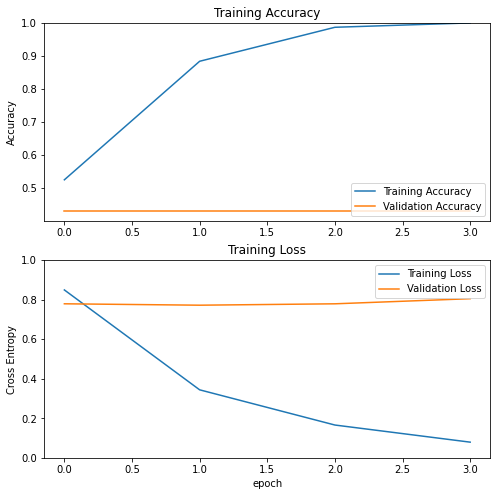

4/4 [==============================] - 0s 9ms/step - loss: 0.4318 - binary_accuracy: 1.0000
Test accuracy: 1.0000
Test loss: 0.4318


In [135]:
evaluate(history)
test_loss, test_accuracy = RNN_model.evaluate(np.asarray(test_features), np.array(test_labels))
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

In [ ]:
prediction = np.squeeze(RNN_model.predict(np.asarray(test_features)) ) #numpy.ndarray df_features[train_border:]
truth =  np.asarray(test_labels)# np.asarray(X2_train[train_border:]) #numpy.ndarray
result = np.asarray((prediction > 0.5)==truth)
output_temp = pd.DataFrame({'prediction': prediction, 'truth': truth, 'result': result}, columns=['prediction', 'truth', 'result'] )
pd.set_option('display.max_rows', None)
print(output_temp[0:100])
pd.set_option('display.max_rows', 10)


#LET'S USE THE MODEL AS A BASELINE FOR SUICIDAL CLASSIFICARTION

In [137]:

# RNN_model.trainable = False
# MNT_model = tf.keras.Sequential([
#     RNN_model,
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(1,activation='sigmoid')
# ])

# MNT_model.compile(
#     optimizer = 'RMSprop',
#     loss = 'binary_crossentropy',
#     metrics = ['accuracy']
# )


In [138]:
# history = MNT_model.fit(
#     np.asarray(bow_features_kaggle),
#     np.asarray(train_labels_kaggle)
#     validation_split=0.1
#     epochs=10
# )


In [139]:
# Evaluation Part
# v, bowtestKaggle_features, tfidftestKaggle_features = BOW_TFIDF(test_sentences_kaggle)


In [140]:
# test_loss, test_accuracy = MNT_model.evaluate(np.asarray(bowtestKaggle_features), np.asarray(test_labels_kaggle))

# print(f'Test accuracy: {test_accuracy:.4f}')
# print(f'Test loss: {test_loss:.4f}')

#LSTM

In [141]:
# import numpy as np
# from tqdm import tqdm
# from tabulate import tabulate
# from sklearn.model_selection import KFold
# from keras.models import Model
# from keras.layers import Dense, Embedding, Input
# from keras.layers import LSTM, GlobalMaxPool1D, Dropout, BatchNormalization
# from keras.preprocessing import text, sequence
# from keras.callbacks import EarlyStopping

In [142]:
# def build_LSTM(args):
#     # From XiongJi's Github
#     inp = Input(shape=(args.max_seq_len, ))
#     # x = Embedding(input_dim=args.max_num_words, output_dim=args.embedding_dim)(inp)
#     # x = LSTM(units=args.lstm_units, activation='tanh', dropout=args.dropout_rate, return_sequences=True)(x)
#     # x = GlobalMaxPool1D()(x)
#     # x = Dropout(args.dropout_rate)(x)
#     # x = BatchNormalization()(x)
#     # x = Dense(args.dense_units, activation="relu")(x)
#     # x = Dropout(args.dropout_rate)(x)
#     # x = BatchNormalization()(x)
#     # x = Dense(1, activation="sigmoid")(x)

#     # TODO: Nabila, please modify this part use tf.keras instead of keras.model
#     # model = tf.keras.Sequential([
#     #     tf.keras.layers.Dense(16,activation='relu',input_shape=(NUM_WORDS,)),
#     # ])

#     model = Model(inputs=inp, outputs=x)

#     model.compile(
#         loss='binary_crossentropy', 
#         # OR 'sparse_categorical_crossentropy' for multiclassifcation
#         optimizer='adam', 
#         # OR 'RMSprop'
#         metrics=['accuracy'])
#     return model
